In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import xgboost
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import shap
import seaborn as sns
import requests

from scripts.check_overlaps import check_overlaps
from make_dataset import make_dataset_censored,  make_dataset_uncensored, repeat_masker, COSMIC_CGC_interactions, TF_binding_site_annotations, create_vep_input, read_vcf

In [4]:
df = pd.read_csv('data/dataset_uncensored.csv')
df = repeat_masker(df)
df = COSMIC_CGC_interactions(df)
df = TF_binding_site_annotations(df)
df

,chr,start,ref,alt,id,end,driver,data_source,DNA,LINE,...,known_driver_gene_100kb_downstream,known_driver_gene_100kb_upstream,known_driver_gene_10kb_downstream,known_driver_gene_10kb_upstream,known_driver_gene_2kb_downstream,known_driver_gene_2kb_upstream,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff
0,1,1342375,A,G,mut943,1342375,0,COSMIC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
1,1,2489274,G,A,mut245,2489274,1,ICGC,0,0,...,0,0,0,0,0,0,0.0,1.0,0.000000,0.934233
2,1,2492155,T,A,mut244,2492155,1,ICGC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
3,1,16477460,T,C,mut124,16477460,1,ICGC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
4,1,19114389,G,A,mut976,19114389,0,COSMIC,0,0,...,1,0,0,0,0,0,2.0,0.0,1.025076,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,X,142919453,A,G,mut866,142919453,0,COSMIC,0,1,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
1082,X,145999464,G,T,mut836,145999464,0,COSMIC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
1083,X,148496412,G,T,mut661,148496412,0,COSMIC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
1084,X,152710276,C,T,mut927,152710276,0,COSMIC,0,0,...,0,1,0,0,0,0,0.0,0.0,0.000000,0.000000


Interactions

In [ ]:
int_df = pd.read_csv('artifacts/final_interactions_result.csv')
int_df = int_df.groupby(['chr', 'start', 'pos_37', 'driver']).agg(max).reset_index(drop=False)
merged_int = raw_data.merge(int_df[['chr', 'pos_37', 'CTCF_interactions', 'CTCF_chains', 'POLR2A_interactions', 'POLR2A_chains']], how='left', left_on=['chr', 'start'], right_on=['chr', 'pos_37'])
merged_int.fillna(0, inplace = True) #For 2:242760774 and 1:142858610
merged_int['CTCF_interactions'] = merged_int['CTCF_interactions'].apply(lambda x: int(x))
merged_int['CTCF_chains'] = merged_int['CTCF_chains'].apply(lambda x: int(x))
merged_int['POLR2A_interactions'] = merged_int['POLR2A_interactions'].apply(lambda x: int(x))
merged_int['POLR2A_chains'] = merged_int['POLR2A_chains'].apply(lambda x: int(x))
merged_int.drop('pos_37', inplace = True, axis = 1)
merged_int

In [6]:
raw_data = raw_data.merge(merged_int, how = 'left', left_on = ['chr', 'start', 'ref', 'alt', 'id', 'driver'], right_on = ['chr', 'start', 'ref', 'alt', 'id', 'driver'])

RepeatMasker

In [23]:
def repeat_masker():
    rpt_masker = pd.read_pickle('artifacts/repeat_masker.pickle')
    rpt_masker = rpt_masker[['chrom', 'start', 'end', 'repClass', 'driver']] #driver
    rpt_masker = pd.concat([rpt_masker.drop('repClass', axis = 1), rpt_masker['repClass'].str.get_dummies().drop(['Low_complexity', 'Satellite', 'snRNA'], axis = 1)], axis = 1)
    rpt_masker = rpt_masker.drop_duplicates(keep='first').reset_index(drop = True)
    rpt_masker
    raw_data = raw_data.merge(rpt_masker, how='left', left_on=['chr','start', 'end', 'driver'], right_on=['chrom','start', 'end', 'driver'])
    raw_data.drop(['chrom'], inplace=True, axis=1)
    raw_data.fillna(0, inplace = True)
    raw_data = raw_data.astype({'DNA': 'int', 'LINE': 'int', 'LTR': 'int', 'SINE': 'int', 'Simple_repeat': 'int'})
    raw_data = raw_data.groupby(['chr', 'start', 'ref', 'alt']).max().reset_index()
    return raw_data

COSMIC Cancer Gene Census Interactions

In [26]:
def COSMIC_CGC_interactions():
    gene_df = pd.read_pickle('artifacts/gencode_interactions.pickle')
    gene_df.drop_duplicates(subset=['grch37_chr', 'grch37_start'], inplace = True)
    gene_df['interaction_info'] = gene_df['interaction_info'].replace('0kb', 'known_driver_gene')
    gene_df['interaction_info'] = gene_df['interaction_info'].replace('100kb downstream', 'known_driver_gene_100kb_downstream')
    gene_df['interaction_info'] = gene_df['interaction_info'].replace('100kb upstream', 'known_driver_gene_100kb_upstream')
    gene_df['interaction_info'] = gene_df['interaction_info'].replace('10kb downstream', 'known_driver_gene_10kb_downstream')
    gene_df['interaction_info'] = gene_df['interaction_info'].replace('10kb upstream', 'known_driver_gene_10kb_upstream')
    gene_df['interaction_info'] = gene_df['interaction_info'].replace('2kb downstream', 'known_driver_gene_2kb_downstream')
    gene_df['interaction_info'] = gene_df['interaction_info'].replace('2kb upstream', 'known_driver_gene_2kb_upstream')
    raw_data = raw_data.merge(gene_df[['grch37_chr', 'grch37_start', 'interaction_gene', 'interaction_info']], how='left', left_on=['chr', 'start'], right_on=['grch37_chr', 'grch37_start'])
    raw_data.drop(['grch37_chr', 'grch37_start'], inplace=True, axis=1)
    raw_data = pd.concat([raw_data.drop(['interaction_gene', 'interaction_info'], axis = 1), raw_data['interaction_info'].str.get_dummies()], axis = 1)
    return raw_data

TF Binding Site

In [ ]:
def TF_binding_site_annotations():
    tf = pd.read_csv('artifacts/vep_loss_gain_data_0.001_3o.csv')
    tf['chr'] = tf['chr'].str.replace('chr', '')
    tf['start'] = tf['start'] + 1
    raw_data = raw_data.merge(tf[['chr', 'start', 'ref', 'alt', 'driver', 'TF_loss', 'TF_gain', 'TF_loss_diff', 'TF_gain_diff']], how='left',
                            left_on=['chr', 'start', 'ref', 'alt', 'driver'], right_on=['chr', 'start', 'ref', 'alt', 'driver'])
    fix_start = list(raw_data[raw_data['TF_loss'].isna()]['start'])

    for index, row in raw_data.iterrows():
        if row['start'] in fix_start:
            if len(tf[(tf['start'] == row['start'] + 1) & (tf['chr'] == row['chr'])]) == 1:
                raw_data.at[index, 'TF_loss'] = tf[(tf['start'] == row['start'] + 1) & (tf['chr'] == row['chr'])].iloc[0]['TF_loss']
                raw_data.at[index, 'TF_gain'] = tf[(tf['start'] == row['start'] + 1) & (tf['chr'] == row['chr'])].iloc[0]['TF_gain']
                raw_data.at[index, 'TF_loss_diff'] = tf[(tf['start'] == row['start'] + 1) & (tf['chr'] == row['chr'])].iloc[0]['TF_loss_diff']
                raw_data.at[index, 'TF_gain_diff'] = tf[(tf['start'] == row['start'] + 1) & (tf['chr'] == row['chr'])].iloc[0]['TF_gain_diff']
            
    raw_data['TF_loss'] = raw_data['TF_loss'].fillna(0)
    raw_data['TF_gain'] = raw_data['TF_gain'].fillna(0)
    raw_data['TF_loss_diff'] = raw_data['TF_loss_diff'].fillna(0)
    raw_data['TF_gain_diff'] = raw_data['TF_gain_diff'].fillna(0)
    return raw_data

In [30]:
raw_data

,chr,start,ref,alt,id,end,driver,data_source,DNA,LINE,...,known_driver_gene_100kb_downstream,known_driver_gene_100kb_upstream,known_driver_gene_10kb_downstream,known_driver_gene_10kb_upstream,known_driver_gene_2kb_downstream,known_driver_gene_2kb_upstream,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff
0,1,1342375,A,G,mut943,1342375,0,COSMIC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
1,1,2489274,G,A,mut245,2489274,1,ICGC,0,0,...,0,0,0,0,0,0,0.0,1.0,0.000000,0.934233
2,1,2492155,T,A,mut244,2492155,1,ICGC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
3,1,16477460,T,C,mut124,16477460,1,ICGC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
4,1,19114389,G,A,mut976,19114389,0,COSMIC,0,0,...,1,0,0,0,0,0,2.0,0.0,1.025076,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,X,142919453,A,G,mut866,142919453,0,COSMIC,0,1,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
1082,X,145999464,G,T,mut836,145999464,0,COSMIC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
1083,X,148496412,G,T,mut661,148496412,0,COSMIC,0,0,...,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000
1084,X,152710276,C,T,mut927,152710276,0,COSMIC,0,0,...,0,1,0,0,0,0,0.0,0.0,0.000000,0.000000


Creating the input file for VEP

In [116]:
def create_vep_input(df, filename):
    df['qual'] = '.'
    df['filter'] = '.'
    df['info'] = '.'
    df['format'] = '.'
    df = df[['chr', 'start', 'id', 'ref', 'alt', 'qual', 'filter', 'info', 'format']]
    header = """##fileformat=VCFv4.1
##FILTER=<ID=PASS,Description="All filters passed">
##INFO=<>
##source=Test
##fileDate=20210728
##reference=hg19
##contig=<ID=chr1,length=249250621>
##contig=<ID=chr2,length=243199373>
##contig=<ID=chr3,length=198022430>
##contig=<ID=chr4,length=191154276>
##contig=<ID=chr5,length=180915260>
##contig=<ID=chr6,length=171115067>
##contig=<ID=chr7,length=159138663>
##contig=<ID=chr8,length=146364022>
##contig=<ID=chr9,length=141213431>
##contig=<ID=chr10,length=135534747>
##contig=<ID=chr11,length=135006516>
##contig=<ID=chr12,length=133851895>
##contig=<ID=chr13,length=115169878>
##contig=<ID=chr14,length=107349540>
##contig=<ID=chr15,length=102531392>
##contig=<ID=chr16,length=90354753>
##contig=<ID=chr17,length=81195210>
##contig=<ID=chr18,length=78077248>
##contig=<ID=chr19,length=59128983>
##contig=<ID=chr20,length=63025520>
##contig=<ID=chr21,length=48129895>
##contig=<ID=chr22,length=51304566>
##contig=<ID=chrX,length=155270560>
##INDIVIDUAL=<NAME=sample01, ID=sample010101>
#CHROM  POS ID  REF ALT QUAL    FILTER  INFO    FORMAT
"""
    with open(filename, 'w') as vcf:
        vcf.write(header)

    df.to_csv(filename, sep='\t', mode='a', index=False, header=False)
    return df

In [117]:
df = create_vep_input(raw_data, "test.vcf")
df

,chr,start,id,ref,alt,qual,filter,info,format
0,1,1342375,mut943,A,G,.,.,.,.
1,1,2489274,mut245,G,A,.,.,.,.
2,1,2492155,mut244,T,A,.,.,.,.
3,1,16477460,mut124,T,C,.,.,.,.
4,1,19114389,mut976,G,A,.,.,.,.
...,...,...,...,...,...,...,...,...,...
1081,X,142919453,mut866,A,G,.,.,.,.
1082,X,145999464,mut836,G,T,.,.,.,.
1083,X,148496412,mut661,G,T,.,.,.,.
1084,X,152710276,mut927,C,T,.,.,.,.


Reading VEP output

In [32]:
def read_vcf(path):
    """Reads a VCF format text file"""
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    df = pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})
    return df

In [101]:
vcf = read_vcf('data/vep_output_all.txt')

Clean and preprocess both sets

In [103]:
def clean_and_preprocess(df):
    # drop columns with only one unique value
    cols_to_drop = []

    for col in df.columns:
        if len(df[col].unique()) == 1:
            cols_to_drop.append(col)

    df.drop(cols_to_drop, axis = 1, inplace = True)

    df.replace('-', np.nan, inplace = True)

    # drop columns that are more than 50% null
    check = df.isnull().sum() / len(df) 
    cols = check[check > 0.5].index
    
    COLS_TO_DROP_INTUITION = ['Gene', 'Feature',
       'HGVSc', 'Existing_variation', 'DISTANCE', 'SYMBOL_SOURCE',
       'HGNC_ID', 'MaxEntScan_alt', 'MaxEntScan_diff', 'MaxEntScan_ref',
       'PHENOTYPES', 'AA', 'SOMATIC', 'PHENO', 'INTRON', 'SpliceAI_pred_SYMBOL', 'TSL']
    
    COLS_TO_KEEP = ['ada_score', 'rf_score', 'LOEUF', 'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
       'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
       'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL',
        'CADD_PHRED', 'CADD_RAW', 'GO']

    COLS_TO_DROP = list(cols) + COLS_TO_DROP_INTUITION
    COLS_TO_DROP = [i for i in COLS_TO_DROP if i not in COLS_TO_KEEP]
    for col in COLS_TO_DROP:
        if col in df.columns:
            df.drop(col, axis = 1, inplace = True)

    df = df.fillna({'STRAND': 0,
                         'ada_score': 0, 'rf_score': 0,
                         'LOEUF': 0,
                        'SpliceAI_pred_DP_AG': 0, 'SpliceAI_pred_DP_AL': 0, 'SpliceAI_pred_DP_DG': 0,
                        'SpliceAI_pred_DP_DL': 0, 'SpliceAI_pred_DS_AG': 0, 'SpliceAI_pred_DS_AL': 0,
                        'SpliceAI_pred_DS_DG': 0, 'SpliceAI_pred_DS_DL': 0,
                        'CADD_PHRED': 0, 'CADD_RAW': 0})

    df = df.astype({'STRAND': 'int', 'ada_score': 'float', 'rf_score': 'float', 'LOEUF': 'float',
                        'SpliceAI_pred_DP_AG': 'float', 'SpliceAI_pred_DP_AL': 'float', 'SpliceAI_pred_DP_DG': 'float',
                        'SpliceAI_pred_DP_DL': 'float', 'SpliceAI_pred_DS_AG': 'float', 'SpliceAI_pred_DS_AL': 'float',
                        'SpliceAI_pred_DS_DG': 'float', 'SpliceAI_pred_DS_DL': 'float',
                        'CADD_PHRED': 'float', 'CADD_RAW': 'float'})
    
    df['Allele'] = df['Allele'].fillna('-')
    df['SYMBOL'] = df.groupby('#Uploaded_variation').SYMBOL.transform('first') # to fill in the null SYMBOLs for some variants
    
    df_dummies = pd.concat([df.drop(['Consequence', 'IMPACT', 'Feature_type', 'BIOTYPE'], axis = 1, inplace = False),
                    df['Consequence'].str.get_dummies(sep=","),
                    df['IMPACT'].str.get_dummies(),
                    df['Feature_type'].str.get_dummies(),
                    df['BIOTYPE'].str.get_dummies()], axis = 1)
    
    agg_dict = {c: 'max' for c in df_dummies.columns}
    agg_dict['ENSP'] = lambda x: ','.join(set(x.dropna()))
    agg_dict['UNIPARC'] = lambda x: ','.join(set(x.dropna()))
    agg_dict['GO'] = lambda x: ','.join(set(x.dropna()))
    
    df_grp = df_dummies.groupby(['#Uploaded_variation', 'Allele'], as_index=False).agg(agg_dict)
    df_grp.columns = df_grp.columns.get_level_values(0)
    
    df_grp['ENSP'] = [len(set(x.split(','))) for x in df_grp['ENSP']]
    df_grp['UNIPARC'] = [len(set(x.split(','))) for x in df_grp['UNIPARC']]
    df_grp['GO'] = [len(set(x.split(','))) for x in df_grp['GO']]

    df_grp['chr'] = df_grp['Location'].str.split(':').str[0]
    df_grp['start'] = df_grp['Location'].str.split(':').str[1].str.split('-').str[0]
    df_grp['end'] = df_grp['Location'].str.split(':').str[1].str.split('-').str[1]
    df_grp['start'] = pd.to_numeric(df_grp['start'])
    df_grp['end'] = pd.to_numeric(df_grp['end'])
    return df_grp

In [ ]:
df = clean_and_preprocess(vcf)
df

In [110]:
data = df.merge(raw_data, left_on='#Uploaded_variation', right_on='id')
data.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)

In [ ]:
df = clean_and_preprocess(vcf)
pos_df = raw_data[raw_data['driver'] == 1]
# df = df.merge(pos_df, how='left', left_on=['chr', 'start', 'ref', 'Allele',], right_on=['chr', 'start', 'ref', 'alt'])
df = df.merge(pos_df, how='left', left_on=['#Uploaded_variation',], right_on=['id'])
df.drop(['end', 'id'],inplace = True, axis = 1)

# COLS_TO_KEEP = ['Consequence', 'IMPACT', 'Feature_type', 'BIOTYPE', 'STRAND'] + (list(df.columns))

# negdf = clean_and_preprocess_negative(vcfneg, COLS_TO_KEEP)
# negdf = negdf[negdf['start'] != 45976823].reset_index(drop = True)
# neg_df = raw_data[raw_data['driver'] == 0]
# negdf = negdf.merge(neg_df, how='left', left_on=['chr', 'start'], right_on=['chr', 'start'])
# negdf.drop(['end', 'id'], axis = 1, inplace = True)

# cols_to_add_in_pos = set(negdf.columns) - set(df.columns)
# for col in cols_to_add_in_pos:
#     df[col] = 0

# cols_to_add_in_neg = set(df.columns) - set(negdf.columns)
# for col in cols_to_add_in_neg:
#     negdf[col] = 0

# df['driver'] = df['driver'].fillna(1)
# negdf['driver'] = negdf['driver'].fillna(0)

# data = pd.concat([df, negdf], ignore_index=True)
# data.drop(['start', 'ref', 'chr_x', 'start_x', 'chr_y', 'start_y', 'ref_y'], inplace = True, axis = 1)
# # data

In [14]:
# negdf.to_csv('vep_output_negative.csv', index = False)
data.to_csv('final_dataset.csv', index = False)

In [ ]:
data.to_csv('final_dataset_all_columns.csv', index = False)#[data['start'] == 101578233]

In [ ]:
data['ada_score'].describe()

# XGBoost

In [111]:
# data = pd.read_csv('data/final_dataset.csv')
data
# df = data[data['driver'] == 1]
# negdf = data[data['driver'] == 0]

,Allele,SYMBOL,STRAND,ENSP,UNIPARC,LOEUF,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,...,known_driver_gene_100kb_downstream_y,known_driver_gene_100kb_upstream_y,known_driver_gene_10kb_downstream_y,known_driver_gene_10kb_upstream_y,known_driver_gene_2kb_downstream_y,known_driver_gene_2kb_upstream_y,TF_loss_y,TF_gain_y,TF_loss_diff_y,TF_gain_diff_y
0,-,PCNP,1,5,4,0.469,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.000000
1,-,PCNP,1,5,4,0.469,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.000000
2,A,SNF8,1,9,9,0.883,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,1.0,0.0,2.175167
3,C,SPATS2,1,16,13,0.319,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,1.0,0.0,1.589926
4,T,ZNF250,-1,9,9,0.499,48.0,-32.0,-45.0,-31.0,...,0,0,0,0,0,0,0.0,2.0,0.0,2.167316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,A,SOGA1,-1,9,8,0.000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.000000
1082,CCCCCCCCCCCCCCCCCCCC,SPNS3,1,2,2,1.117,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.000000
1083,A,NaN,0,1,1,0.000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.000000
1084,A,PRSS41,1,2,2,0.000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.000000


In [112]:
data[['GO', 'ENSP', 'UNIPARC']].describe()

,GO,ENSP,UNIPARC
count,1086.000000,1086.000000,1086.000000
mean,16.396869,5.123389,4.439227
std,20.808009,8.196519,5.928257
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,9.000000,2.000000,2.000000
75%,26.000000,6.000000,5.000000
max,148.000000,145.000000,65.000000


In [113]:
data['TF_binding_site_agg'] = np.logical_or(data['TF_binding_site'], data['TF_binding_site_variant']).astype(int)

data['TF_loss_add'] = data['TF_binding_site_agg'] + data['TF_loss']
data['TF_gain_add'] = data['TF_binding_site_agg'] + data['TF_gain']
data['TF_loss_diff_add'] = data['TF_binding_site_agg'] + data['TF_loss_diff']
data['TF_gain_diff_add'] = data['TF_binding_site_agg'] + data['TF_gain_diff']
# data['TF_loss_diff_mul'] = data['TF_binding_site_agg'] * data['TF_loss_diff']
# data['TF_gain_diff_mul'] = data['TF_binding_site_agg'] * data['TF_gain_diff']

# data['TF_loss_mul'] = data['TF_binding_site_agg'] * data['TF_loss']
# data['TF_gain_mul'] = data['TF_binding_site_agg'] * data['TF_gain']

data['SpliceAI_pred_DP_AG'] = abs(data['SpliceAI_pred_DP_AG'])
data['SpliceAI_pred_DP_AL'] = abs(data['SpliceAI_pred_DP_AL'])
data['SpliceAI_pred_DP_DG'] = abs(data['SpliceAI_pred_DP_DG'])
data['SpliceAI_pred_DP_DL'] = abs(data['SpliceAI_pred_DP_DL'])

metadata = pd.read_csv(r'Interactions/ChIA-PET/metadata.tsv', sep='\t')
files_to_keep = list(metadata[~(metadata['Biosample term name'].str.contains('positive')) & ~(metadata['Biosample term name'].str.contains('activated')) & ~(metadata['Biosample term name'].str.contains('T-cell'))]['File accession'])
# mcf = list(metadata[(metadata['Biosample term name'].str.contains('MCF-7'))]['File accession'])
metadata = metadata[metadata['File accession'].isin(files_to_keep)]
# CTCF_total = metadata['Experiment target'].value_counts()['CTCF-human']
# POLR2A_total = metadata['Experiment target'].value_counts()['POLR2A-human']
CTCF_total = 39166005
POLR2A_total = 15622208
data[['CTCF_interactions', 'CTCF_chains']] = data[['CTCF_interactions', 'CTCF_chains']]/CTCF_total
data[['POLR2A_interactions', 'POLR2A_chains']] = data[['POLR2A_interactions', 'POLR2A_chains']]/POLR2A_total
data['CTCF_interactions'] = data['CTCF_interactions']*100
data['CTCF_chains'] = data['CTCF_chains']*100
data['POLR2A_interactions'] = data['POLR2A_interactions']*100
data['POLR2A_chains'] = data['POLR2A_chains']*100

KeyError: 'TF_loss'

In [4]:
XGB_PARAMS = {                                            # CODE SOURCE: containers_build\boostdm\config.py
        "objective": "binary:logistic",
        "reg_lambda": 1,
        "random_state": 42,
        "scale_pos_weight": 1,
        "subsample": 0.7,        # fraction of observations to be random samples for each tree
        "reg_alpha": 0,          # L1 regularization term on weight
        "max_delta_step": 0,    # positive value can help make the update step more conservative. generally not used
        "min_child_weight": 1,
        "learning_rate": 1e-03,
        "colsample_bylevel": 1.0,
        "gamma": 0,     # specifies the minimum loss reduction required to make a split. Makes the algorithm conservative
        "colsample_bytree": 1.0,        # fraction of columns to be random samples for each tree
        "booster": "gbtree",
        "max_depth": 4, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
        "silent": 1,
        "seed": 21,
        "eval_metric": 'logloss',
        "early_stopping_rounds": 2000
        # "reg_lambda": 1,  # explore this further

}

# 'ada_score', 'rf_score', 'CADD_PHRED', 'CADD_RAW', 'MODERATE', 'LOW', 'SWISSPROT', 'TREMBL', 'miRNA', 'sense_overlapping', 'misc_RNA'
# 'IG_D_gene', 'IG_J_gene', 'IG_C_gene', 'transcribed_unprocessed_pseudogene', 'non_stop_decay', '3prime_overlapping_ncRNA', 'pseudogene', 'transcribed_processed_pseudogene', 'rNA'
# 'missense_variant', 'synonymous_variant', 'stop_gained', 'stop_lost', 'splice_region_variant', 'inframe_insertion', 'start_lost', 'inframe_deletion', 'frameshift_variant' # not in positive set
# 'splice_acceptor_variant', 'coding_sequence_variant', 'splice_donor_region_variant', 'splice_donor_5th_base_variant' # not in negative set
# open_chromatin_region, 'snRNA', 'snoRNA' # not enough values
# 'STRAND', 'TF_binding_site_variant', 'TF_binding_site', 

COLUMNS_TRAINING = ['ada_score', 'rf_score',
        'ENSP', 'UNIPARC', 'GO',
       'LOEUF', 'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
       'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
       'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL',
       '3_prime_UTR_variant', '5_prime_UTR_variant',
       'NMD_transcript_variant', 
       'downstream_gene_variant',
       'intergenic_variant', 'intron_variant', 'mature_miRNA_variant',
       'non_coding_transcript_exon_variant', 'non_coding_transcript_variant',
       'regulatory_region_variant',
       'splice_donor_variant', 'splice_polypyrimidine_tract_variant',
       'upstream_gene_variant', 'MODIFIER', 'MotifFeature',
       'RegulatoryFeature', 'Transcript', 'CTCF_binding_site',
       'antisense', 'enhancer', 'lincRNA', 'nonsense_mediated_decay',
       'processed_pseudogene', 'processed_transcript', 'promoter',
       'promoter_flanking_region', 'protein_coding', 'retained_intron',
       'sense_intronic', 'unprocessed_pseudogene',
       'CTCF_interactions', 'CTCF_chains', 'POLR2A_interactions', 'POLR2A_chains',
       'DNA', 'LINE', 'LTR', 'SINE', 'Simple_repeat',
       'known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream',
       'known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream',
       'splice_acceptor_variant', 'coding_sequence_variant', 'splice_donor_region_variant', 'splice_donor_5th_base_variant',
       'missense_variant', 'synonymous_variant', 'stop_gained', 'stop_lost', 'splice_region_variant', 'inframe_insertion', 'start_lost', 'inframe_deletion', 'frameshift_variant',
#        'TF_loss_diff', 'TF_gain_diff', 'TF_loss_mul', 'TF_gain_mul', 
#        'TF_loss_diff_mul', 'TF_gain_diff_mul', 'TF_loss_mul', 'TF_gain_mul'
       'TF_loss_add', 'TF_gain_add', 'TF_loss_diff_add', 'TF_gain_diff_add'
#        'TF_binding_site_agg',
#        'MODERATE', 'transcribed_unprocessed_pseudogene', 'non_stop_decay', 'IG_J_pseudogene', 'sense_overlapping',
#         'IG_J_gene',  'IG_D_gene',  'transcribed_processed_pseudogene',  '3prime_overlapping_ncRNA',  'pseudogene',  'rRNA',
#         'IG_C_gene'
    ]

# BIASED_COLUMNS = list(df.loc[:, df.nunique() == 1].columns) + list(negdf.loc[:, negdf.nunique() == 1].columns)
BIASED_COLUMNS = ['chr', 'ref_x', 'IG_C_gene', 'IG_D_gene', 'IG_J_gene', 'IG_J_pseudogene']
# BIASED_COLUMNS.remove('driver')
# BIASED_COLUMNS.remove('driver')
# BIASED_COLUMNS.remove('splice_acceptor_variant')

COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x not in BIASED_COLUMNS]

COLUMNS_SHAP = [f'my_shap_{x}' for x in COLUMNS_TRAINING]

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

data[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data[COLUMNS_TRAINING])

valset = data[-5:]
data = data[:-5]
valset['driver']

1081    0
1082    0
1083    0
1084    0
1085    0
Name: driver, dtype: int64

In [52]:
data[['CTCF_interactions', 'CTCF_chains']]

,CTCF_interactions,CTCF_chains
0,0.045461,0.047401
1,0.045408,0.047355
2,0.260037,0.247712
3,0.497041,0.486300
4,0.192154,0.192584
...,...,...
1076,0.035678,0.037430
1077,0.195427,0.207208
1078,0.608857,0.591308
1079,0.114314,0.109699


In [27]:
len(COLUMNS_TRAINING)
# data

77

Boxplot

In [ ]:
COLUMNS_TRAINING_LABELS = [item[:14] + '\n' + item[14:] for item in COLUMNS_TRAINING]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(30, 60))

bplot1 = ax1.boxplot(data[COLUMNS_TRAINING].iloc[:, 0:10],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[0:10])

bplot2 = ax2.boxplot(data[COLUMNS_TRAINING].iloc[:, 10:20],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[10:20])

bplot3 = ax3.boxplot(data[COLUMNS_TRAINING].iloc[:, 20:30],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[20:30])

bplot4 = ax4.boxplot(data[COLUMNS_TRAINING].iloc[:, 30:40],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[30:40])

bplot5 = ax5.boxplot(data[COLUMNS_TRAINING].iloc[:, 40:50],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[40:50])

bplot6 = ax6.boxplot(data[COLUMNS_TRAINING].iloc[:, 50:len(COLUMNS_TRAINING)],
                     vert=True,
                     patch_artist=True,
                     boxprops = dict(facecolor = "lightblue"),
                     capprops = dict(color = "red", linewidth = 4),
                     labels=COLUMNS_TRAINING_LABELS[50:])

# adding horizontal grid lines
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Features', fontsize=20)
    ax.set_ylabel('Normalized Observed values', fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)

fig.suptitle('Boxplot Normalised Dataset', fontsize=30)
fig.tight_layout(pad=2)
plt.show()

Histogram

In [ ]:
COLUMNS_TRAINING_LABELS = [item[:14] + '\n' + item[14:] for item in COLUMNS_TRAINING]
num = 8
col = 0
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(30, 30))
for i in range(0, num):
    for j in range(0, num):
        colour_dict = {0: 'pink', 1: 'lightblue'}
        axes[i][j].hist([data.loc[data['driver'] == x, COLUMNS_TRAINING[col]] for x in colour_dict.keys()],
                color=[colour_dict[x] for x in colour_dict.keys()],
                edgecolor='black',
                stacked=True)
        axes[i][j].set_xlabel(COLUMNS_TRAINING_LABELS[col], fontsize=20, wrap=True)
        axes[i][j].tick_params(axis='y', labelsize=15)
        axes[i][j].tick_params(axis='x', labelsize=15)

        col = col + 1
        if col >= len(COLUMNS_TRAINING):
            break

fig.suptitle('Histogram of Normalised Dataset', fontsize=30)
fig.legend(colour_dict, labels=['non-driver', 'driver'], loc='upper left', ncol = 2, fontsize=20)
fig.tight_layout(pad=2)

Correlation Matrix

In [ ]:
COLUMNS_WITH_DRIVER = COLUMNS_TRAINING
COLUMNS_WITH_DRIVER.append('driver')
corr_matrix = data[COLUMNS_TRAINING].corr()
matrix = np.triu(corr_matrix)
sns.set(font_scale=0.6)
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(30,30)})
# sns.set(rc=)

ax= sns.heatmap(corr_matrix, mask=matrix, vmin=-1, vmax=+1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .82},annot=True,
            fmt='.1',annot_kws={"size":7}, cmap='coolwarm')

sns.set()
for t in ax.texts:
    if float(t.get_text())>=0.4 or float(t.get_text())<=-0.4:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text

# Sweep using WANDB

In [ ]:
from sklearn import metrics
from scipy.stats import ks_2samp
import wandb
from wandb.xgboost import WandbCallback
import os
os.environ["WANDB_API_KEY"] = '8760ac6e727d4e8b826bb6a5fd5bdf3e2d662a40'

xgboost.set_config(verbosity=0)

In [ ]:
sweep_config = {
  "method" : "grid",
  "parameters" : {
    "learning_rate" :{
      "values": [0.001, 0.005, 0.01]
    },
    "early_stopping_rounds" :{
      "values" : [1000, 2000, 4000]
    },
    "subsample": {    # fraction of observations to be random samples for each tree
      "values": [0.5, 0.7, 0.8, 1.0]
    },
    "max_depth": {
      "values": [4, 6]  
    }, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
  }
}

sweep_id = wandb.sweep(sweep_config, project='thesis', entity='sanabasharat')

def train():
  with wandb.init(job_type="sweep") as run:
    # for i in list_cvs: # for each of the 50 splits
    x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                        random_state=104, 
                                                        test_size=0.25, 
                                                        shuffle=True)         # CODE SOURCE: containers_build\boostdm\training.py LIN 44
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=104) # 0.25 x 0.8 = 0.2
    
    bst_params = {
        'objective': 'binary:logistic'
        , 'base_score': y_train.mean()
        , 'gamma': 0
        , 'learning_rate': run.config['learning_rate']
        , 'max_depth': 3
        , 'n_estimators': 20000
        , 'random_state': 42
        , 'early_stopping_rounds': run.config['early_stopping_rounds']
        , 'eval_metric': 'logloss'
        , 'subsample': run.config['subsample']
        , 'max_depth': run.config['max_depth']
        , 'reg_lambda': 1
        , 'random_state': 42
        , 'scale_pos_weight': 1
        , 'silent': 1
        , 'seed': 21
        , 'reg_alpha': 0         # L1 regularization term on weight
        , 'max_delta_step': 0    # positive value can help make the update step more conservative. generally not used
        , 'min_child_weight': 1
        , 'colsample_bylevel': 1.0
        , 'colsample_bytree': 1.0        # fraction of columns to be random samples for each tree
        , 'booster': 'gbtree'
        , 'n_jobs' : 1
        , 'min_child_weight': 1
    }
    # params = XGB_PARAMS.copy()                                          
    # params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
    # params['base_score'] = y_train.mean()
    # params['n_jobs'] = 1
    # params['seed'] = seed
    model = XGBClassifier(**bst_params)

    # train with xgboost
    # learning_curve_dict = {}
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                        callbacks = [
                            xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False),
                            WandbCallback()
                        ],
                        verbose = 0)

    bst_params['n_estimators'] = model.best_iteration
    model.set_params(**bst_params)
    
    bstr = model.get_booster()

    # Log booster metrics
    run.summary["best_ntree_limit"] = bstr.best_ntree_limit
    
    # Get train and validation predictions
    trnYpreds = model.predict_proba(x_train)[:,1]
    valYpreds = model.predict_proba(x_val)[:,1] 

    # Log additional Train metrics
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, trnYpreds) 
    run.summary['train_ks_stat'] = max(true_positive_rate - false_positive_rate)
    run.summary['train_auc'] = metrics.auc(false_positive_rate, true_positive_rate)
    run.summary['train_log_loss'] = -(y_train * np.log(trnYpreds) + (1-y_train) * np.log(1-trnYpreds)).sum() / len(y_train)

    # Log additional Validation metrics
    ks_stat, ks_pval = ks_2samp(valYpreds[y_val==1], valYpreds[y_val==0])
    run.summary["val_ks_2samp"] = ks_stat
    run.summary["val_ks_pval"] = ks_pval
    run.summary["val_auc"] = metrics.roc_auc_score(y_val, valYpreds)
    run.summary["val_acc_0.5"] = metrics.accuracy_score(y_val, np.where(valYpreds >= 0.5, 1, 0))
    run.summary["val_log_loss"] = -(y_val * np.log(valYpreds) + (1-y_val) * np.log(1-valYpreds)).sum() / len(y_val)

In [ ]:
# count = 10 # number of runs to execute
wandb.agent(sweep_id, function=train)

# Simple run

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                    random_state=104, 
                                                    test_size=0.25, 
                                                    shuffle=True)         # CODE SOURCE: containers_build\boostdm\training.py LIN 44
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=104) # 0.25 x 0.8 = 0.2

params = XGB_PARAMS.copy()                                          
params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
params['base_score'] = y_train.mean()
params['silent'] = True
# params['n_jobs'] = 1
params['seed'] = 104
model = XGBClassifier(**params)

# train with xgboost
# learning_curve_dict = {}
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                    callbacks = [
                        xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False)
                    ],
                    verbose = 1)

params['n_estimators'] = model.best_iteration
model.set_params(**params)

[08:46:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-logloss:0.68757	validation_1-logloss:0.68752
[0]	validation_0-logloss:0.68757	validation_1-logloss:0.68752
[1]	validation_0-logloss:0.68692	validation_1-logloss:0.68687
[1]	validation_0-logloss:0.68692	validation_1-logloss:0.68687
[2]	validation_0-logloss:0.68626	validation_1-logloss:0.68618
[2]	validation_0-logloss:0.68626	validation_1-logloss:0.68618
[3]	validation_0-logloss:0.68558	validation_1-logloss:0.68551
[3]	validation_0-logloss:0.68558	validation_1-logloss:0.68551
[4]	validation_0-logloss:0.68494	validation_1-logloss:0.68483
[4]	validation_0-logloss:0.68494	validation_1-logloss:0.68483
[5]	validation_0-logloss:0.68426	validation_1-logloss:0.68416
[5]	validation_0-logloss:0.68426	validation_1-logloss:0.68416
[6]	validation_0-logloss:0.68360	validation_1-logloss:0.68352
[6]	validation_0-logloss:0.68360	validation_1-logloss:

`callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.


[19]	validation_0-logloss:0.67503	validation_1-logloss:0.67505
[19]	validation_0-logloss:0.67503	validation_1-logloss:0.67505
[20]	validation_0-logloss:0.67439	validation_1-logloss:0.67443
[20]	validation_0-logloss:0.67439	validation_1-logloss:0.67443
[21]	validation_0-logloss:0.67375	validation_1-logloss:0.67377
[21]	validation_0-logloss:0.67375	validation_1-logloss:0.67377
[22]	validation_0-logloss:0.67311	validation_1-logloss:0.67316
[22]	validation_0-logloss:0.67311	validation_1-logloss:0.67316
[23]	validation_0-logloss:0.67249	validation_1-logloss:0.67254
[23]	validation_0-logloss:0.67249	validation_1-logloss:0.67254
[24]	validation_0-logloss:0.67183	validation_1-logloss:0.67192
[24]	validation_0-logloss:0.67183	validation_1-logloss:0.67192
[25]	validation_0-logloss:0.67119	validation_1-logloss:0.67128
[25]	validation_0-logloss:0.67119	validation_1-logloss:0.67128
[26]	validation_0-logloss:0.67055	validation_1-logloss:0.67062
[26]	validation_0-logloss:0.67055	validation_1-logloss:

XGBClassifier(base_score=0.4506172839506173, booster='gbtree', callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=2000,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=19998, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

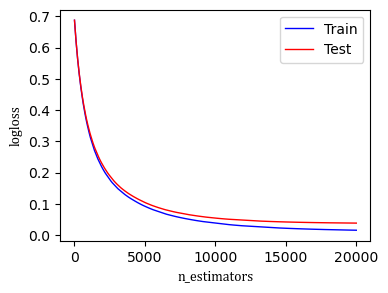

In [6]:
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train', color='blue', linewidth = '1')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test', color='red', linewidth = '1')
ax.legend()
plt.ylabel('logloss',{'fontname':'Cambria'})
plt.xlabel('n_estimators',{'fontname':'Cambria'})
# plt.title('XGBoost logloss', {'fontname':'Cambria'})
plt.show()

In [7]:
yhat = model.predict(x_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)

[08:50:00] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy: 0.989


In [19]:
log_loss(yhat, y_test)

0.39900723308985797

In [24]:
from random import seed
from random import randrange
 
# zero rule algorithm for classification
def zero_rule_algorithm_classification(train, test):
 output_values = [row[-1] for row in train]
 prediction = max(set(output_values), key=output_values.count)
 predicted = [prediction for i in range(len(test))]
 return predicted

train = x_train
train['driver'] = y_train
test = x_test
test['driver'] = y_test
seed(1)
# train = [['0'], ['0'], ['0'], ['0'], ['1'], ['1']]
# test = [[None], [None], [None], [None]]
predictions = zero_rule_algorithm_classification(train, test)
print(predictions)

['t', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't',

In [27]:
train

,ada_score,rf_score,ENSP,UNIPARC,GO,LOEUF,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,...,splice_region_variant,inframe_insertion,start_lost,inframe_deletion,frameshift_variant,TF_loss_add,TF_gain_add,TF_loss_diff_add,TF_gain_diff_add,driver
514,0.000000,0.000000,0.000000,0.00,0.080745,0.435180,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.000000,0.526933,0
884,0.000000,0.000000,0.057971,0.08,0.043478,0.923742,0.48,0.20,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
420,0.000000,0.000000,0.000000,0.00,0.608696,0.288765,0.00,0.64,0.94,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
597,0.000000,0.000000,0.405797,0.42,0.229814,0.819522,0.00,0.00,0.40,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
620,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,0.000000,0.000000,0.043478,0.06,0.074534,0.000000,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
166,0.999987,0.977178,0.072464,0.04,0.055901,0.120996,0.62,0.48,0.90,0.02,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
654,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
729,0.000000,0.000000,0.028986,0.04,0.012422,0.000000,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.205385,0.000000,0


In [46]:
data['driver'].value_counts()

0    594
1    487
Name: driver, dtype: int64

In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
print('precision: ', precision_score(y_test, yhat))
print('recall: ' , recall_score(y_test, yhat))
print('f1_score: ', f1_score(y_test, yhat))
print('roc_auc_score: ', roc_auc_score(y_test, yhat))

precision:  0.976
recall:  1.0
f1_score:  0.9878542510121457
roc_auc_score:  0.9899328859060403


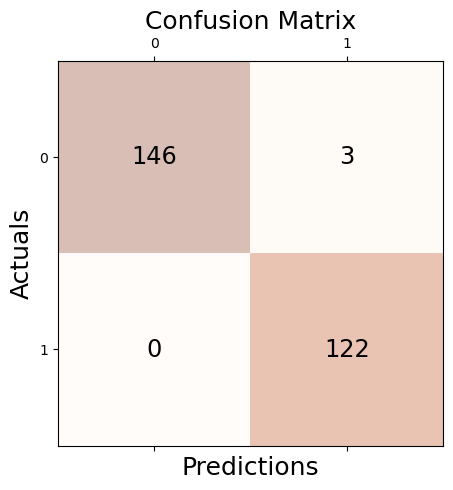

In [10]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=yhat)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [11]:
valsetpred = model.predict(valset[COLUMNS_TRAINING])
print(valset['driver'])
print(valsetpred)

1081    0
1082    0
1083    0
1084    0
1085    0
Name: driver, dtype: int64
[0 0 0 0 0]


SHAP Explainer

In [12]:
# SHAP attribution
x_data = data[COLUMNS_TRAINING]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
# shap_values = np.mean(shap_bootstrap, axis=0)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [13]:
for c in COLUMNS_SHAP:
    data[c] = np.nan
data.loc[data.index, COLUMNS_SHAP] = shap_values

In [82]:
x_data.columns

Index(['ada_score', 'rf_score', 'ENSP', 'UNIPARC', 'GO', 'LOEUF',
       'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL', 'SpliceAI_pred_DP_DG',
       'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', '3_prime_UTR_variant',
       '5_prime_UTR_variant', 'NMD_transcript_variant',
       'downstream_gene_variant', 'intergenic_variant', 'intron_variant',
       'mature_miRNA_variant', 'non_coding_transcript_exon_variant',
       'non_coding_transcript_variant', 'regulatory_region_variant',
       'splice_donor_variant', 'splice_polypyrimidine_tract_variant',
       'upstream_gene_variant', 'MODIFIER', 'MotifFeature',
       'RegulatoryFeature', 'Transcript', 'CTCF_binding_site', 'antisense',
       'enhancer', 'lincRNA', 'nonsense_mediated_decay',
       'processed_pseudogene', 'processed_transcript', 'promoter',
       'promoter_flanking_region', 'protein_coding', 'retained_intron',
       'sense_intronic', 'unprocesse

In [222]:
x_data[['splice_acceptor_variant', 'splice_donor_variant', 'promoter', 'downstream_gene_variant', 'regulatory_region_variant']]#.describe()
# x_data.columns.get_loc('splice_acceptor_variant')
# x_data.columns.get_loc('splice_donor_variant')
# x_data.columns.get_loc('LOEUF')
data['driver'].value_counts()

0    594
1    487
Name: driver, dtype: int64

In [12]:
shap_values[:,[60, 24, 38, 17, 23]]

array([[-0.13597067,  2.6766872 , -0.18800184, -0.4275968 , -0.16208792],
       [ 2.8538291 , -0.161944  , -0.1752132 , -0.4338853 , -0.18583663],
       [-0.17949173, -0.20008492,  0.8131278 , -0.32269755,  0.4714881 ],
       ...,
       [-0.23762952, -0.2643912 , -0.44067252,  0.37529954, -0.4998583 ],
       [-0.26240113, -0.27018514, -0.4058053 ,  0.3271769 , -0.4722336 ],
       [-0.26519302, -0.27057764, -0.40659428, -0.47669762, -0.3986221 ]],
      dtype=float32)

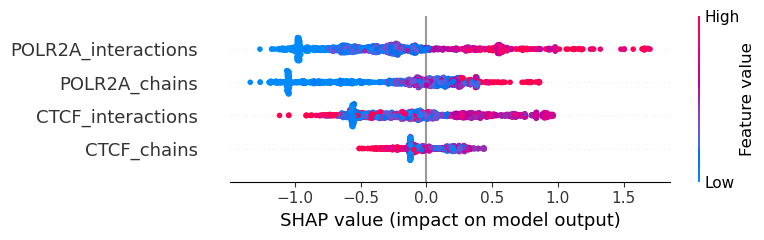

In [17]:
# shap.summary_plot(shap_values[:,2:5], x_data.iloc[:, 2:5], plot_size = 0.25)  # protein product
# shap.summary_plot(shap_values[:,6:14], x_data.iloc[:, 6:14], plot_size = 0.25)  # splice ai
# shap.summary_plot(shap_values[:,0:2], x_data.iloc[:, 0:2], plot_size = 0.25) #ada score rf score
shap.summary_plot(shap_values[:,44:48], x_data.iloc[:, 44:48], plot_size = 0.25)  # interactions
# shap.summary_plot(shap_values[:,53:60], x_data.iloc[:, 53:60], plot_size = 0.25) # cosmic genes
# shap.summary_plot(shap_values[:,48:53], x_data.iloc[:, 48:53], plot_size = 0.25) #repeat masker
# shap.summary_plot(shap_values[:,73:77], x_data.iloc[:, 73:77], plot_size = 0.25)  # tf
# shap.summary_plot(shap_values[:,5:6], x_data.iloc[:, 5:6], plot_size = 0.25)  # loeuf
# shap.summary_plot(shap_values[:,[60, 24, 38, 17, 23]], x_data.iloc[:, [60, 24, 38, 17, 23]], plot_size = 0.25) # the rest

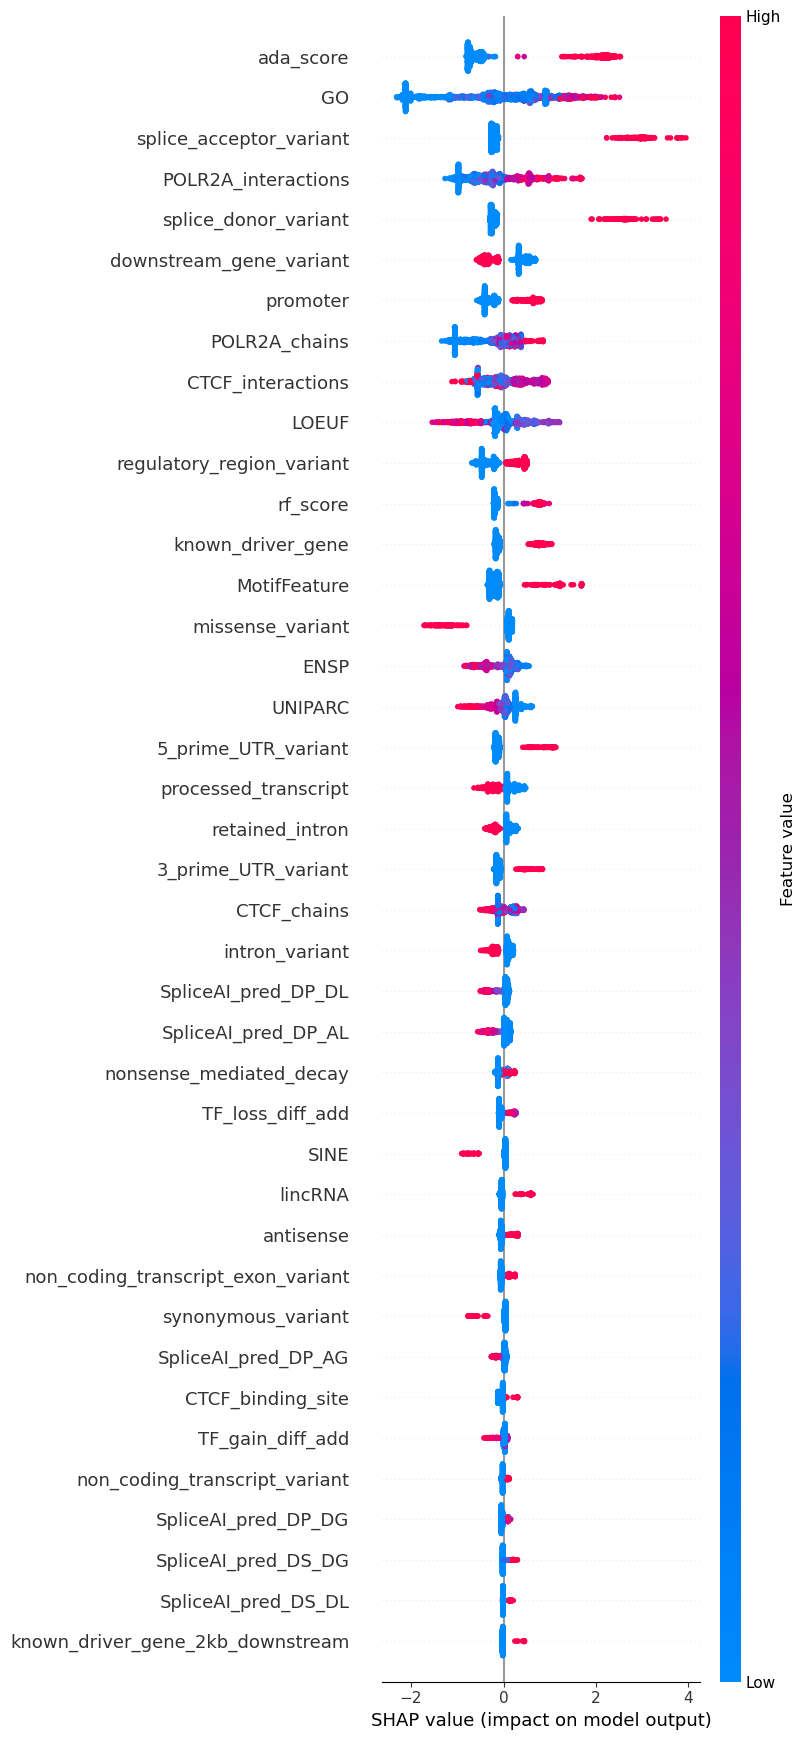

In [18]:
shap.summary_plot(shap_values, x_data, max_display=40)

In [ ]:
shap.dependence_plot("CTCF_interactions", shap_values, x_data, interaction_index="CTCF_chains")

In [ ]:
# shap.plots.heatmap(shap_values)
shap_values_explaination = shap.Explanation(shap_values, feature_names=data[COLUMNS_TRAINING].columns.tolist()) 
shap.plots.heatmap(shap_values_explaination, max_display=12)

In [ ]:
x_data = data[COLUMNS_TRAINING]
explainer = shap.TreeExplainer(model) # grabbing the first model
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[101:200], x_data[101:200])

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=data[COLUMNS_TRAINING].columns)
feat_importances.nlargest(40).plot(kind='barh')

In [ ]:
import pandas as pd
import numpy as np
import os
from anytree import Node, RenderTree, AsciiStyle, LevelGroupOrderIter, LevelOrderGroupIter, search
from intervaltree import Interval, IntervalTree
import multiprocessing
import time

def read_dataset():
    df_pos = pd.read_csv('artifacts/df_grch38.bed', sep='\t', header=None)
    df_pos.columns = ['chr', 'start', 'end']

    orig = pd.read_csv('ICGC_TCGA_noncoding_data.csv')
    df_pos['pos_37'] = orig['pos']
    df_pos.drop_duplicates(keep='first', inplace=True)

    df_neg = pd.read_csv('negdf_grch38.bed', sep='\t', header=None)
    df_neg.columns = ['chr', 'start', 'end', 'old_pos', 'bed_format']
    df_neg['chr'] = df_neg['chr'].apply(lambda x: x.replace('chr', ''))
    df_neg['chr_old'] = df_neg['old_pos'].str.split(':').str[0].str.replace('chr', '')
    df_neg['start_old'] = df_neg['old_pos'].str.split(':').str[1].str.split('-').str[1]
    df_neg['end_old'] = df_neg['old_pos'].str.split(':').str[1].str.split('-').str[0]
    df_neg['start_old'] = pd.to_numeric(df_neg['start_old'])
    df_neg['end_old'] = pd.to_numeric(df_neg['end_old'])
    metadata = pd.read_csv(r'C:\Users\Sana\Downloads\ChiaPET\metadata.tsv', sep='\t')

    df_pos = df_pos[['chr', 'start', 'end', 'pos_37']]
    df_pos['driver'] = 1
    df_pos.drop_duplicates(keep='first', inplace=True)

    df_neg = df_neg[['chr', 'start', 'end', 'start_old']]
    df_neg['driver'] = 0
    df_neg.rename(columns = {'start_old': 'pos_37'}, inplace = True)
    df_neg.drop_duplicates(keep='first', inplace=True)

    df = pd.concat([df_pos, df_neg])
    return df                              # final dataset including negative and positive set

In [ ]:
df = read_dataset()
df.sort_values('chr', inplace=True)
df.reset_index(drop = True, inplace = True)
df['CTCF_interactions'] = 0
df['CTCF_chains'] = 0
df['POLR2A_interactions'] = 0
df['POLR2A_chains'] = 0

chr = '17'
mutation = 50862973
all_files = ['ENCFF271VMZ.bedpe']
for file in all_files:
    print(file)
    cp = pd.read_csv('C:/Users/Sana/Downloads/ChiaPET/' + file, sep = '\t',  header = None)
    cp.columns = ['chr_A', 'start_A', 'end_A', 'chr_B', 'start_B', 'end_B', 'score']
    cp['chr_A'] = cp['chr_A'].map(lambda x: x.replace('chr', ''))
    cp['chr_B'] = cp['chr_B'].map(lambda x: x.replace('chr', ''))
    
    cp = cp[cp['chr_A'] == chr]
    interactions_tree = IntervalTree()

    for index, row in cp.iterrows():
        interactions_tree.add(Interval(row['start_A'], row['end_A'], tuple([row['chr_A'], row['start_B'], row['end_B']]))) # fotwards interaction
        interactions_tree.add(Interval(row['start_B'], row['end_B'], tuple([row['chr_A'], row['start_A'], row['end_A']]))) # backwards interaction
        
    # df_tree = []
    
    # save_tree = interactions_tree.copy()
    # for index, row in df.iterrows():          # this is to make an AnyTree for each mutation in the dataset, and store them all in a list
    #     df_tree.append(Node(name = row['chr'] + ':' + str(row['start']) + '-' + str(row['end']), chr = row['chr'], start = row['start'], end = row['end'], checked = 0))

    # #checking just one mutation
    # df_tree = Node(name = 'artificial', chr = '17', start = 59210051, end = 59210052, checked = 0)
    df_tree = Node(name = 'artificial', checked = 0)
    # df_tree = Node(name = 'artificial', chr = '3', start = 5, end = 6, checked = 0)     # checking just one artificial mutation

    found_overlap = False
    if len(interactions_tree.at(mutation)) > 0:
        found_overlap = True
        for i in interactions_tree.at(mutation):
            Node(Interval(i.data[1], i.data[2]), checked = 0, parent = df_tree)
            interactions_tree.remove(i)
            inv = Interval(i.data[1], i.data[2], tuple([i.data[0], i.begin, i.end]))
            interactions_tree.remove(inv)

    interactions = 0
    chains = 0
    if found_overlap:
        children_left = True
        while children_left is True:
            children_left = False
            for node in df_tree.leaves:
                if node.checked == 0:
                    node.checked = 1
                    found_list = list(interactions_tree.overlap(node.name))
                    for found_node in found_list:
                        print("FOUND: ", found_node)
                        children_left = True
                        Node(name = Interval(found_node.data[1], found_node.data[2]), checked = 0, parent = node)
                        print("REMOVING: ", found_node)
                        try:
                            interactions_tree.remove(found_node)# only remove that node which satisfies both conditions of similarity
                        except:
                            pass
                        try:
                            interactions_tree.remove(Interval(found_node.data[1], found_node.data[2], tuple([found_node.data[0], found_node.begin, found_node.end])))
                        except:
                            pass

        interactions = len(set([k.name for k in df_tree.descendants]))
        chains = sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf])


    # if metadata[metadata['File accession'] == file.replace('.bedpe', '')]['Experiment target'].iloc[0].replace('-human', '') == 'CTCF':
    #     print('CTCF_interactions', len(df_tree.descendants))
    #     print('CTCF_chains', sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf]))
    #     # for index, row in df.iterrows():
    #     #     df.at[index, 'CTCF_interactions'] = row['CTCF_interactions'] + len(df_tree[index].descendants)
    #     #     df.at[index, 'CTCF_chains'] = row['CTCF_chains'] + sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree[index], filter_=lambda node: node.is_leaf and not node.is_root) if leaf])
    # else:
    #     print('POLR2A_interactions', len(df_tree.descendants))
    #     print('POLR2A_chains', sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree, filter_=lambda node: node.is_leaf and not node.is_root) if leaf]))
        # for index, row in df.iterrows():
        #     df.at[index, 'POLR2A_interactions'] = row['POLR2A_interactions'] + len(df_tree[index].descendants)
        #     df.at[index, 'POLR2A_chains'] = row['POLR2A_chains'] + sum(len(x) for x in [leaf for leaf in LevelGroupOrderIter(df_tree[index], filter_=lambda node: node.is_leaf and not node.is_root) if leaf])      

In [ ]:
interactions

In [ ]:
chains

In [ ]:
import pickle
with open('files_to_keep', 'wb') as f:
    pickle.dump(files_to_keep, f)

In [ ]:
len(files_to_keep)

In [ ]:
all_files = os.listdir(r"C:/Users/Sana/Downloads/ChiaPET")
all_files.remove('files.txt')
all_files.remove('metadata.tsv')
all_files = [item for item in all_files if item in files_to_keep]

In [ ]:
files_to_keep = [item + '.bedpe' for item in files_to_keep]

In [ ]:
len([item for item in all_files if item in files_to_keep])